In [1]:
import os
from os.path import join as osj
import sys
sys.path.insert(0, osj(os.getcwd(), "scripts"))

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
from lorenz63 import L63
from eakf import eakf_solver
from helper import *
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from gymnasium import spaces, Env
import gymnasium as gym
from stable_baselines3.common.callbacks import EvalCallback

device = torch.device("cpu")

2025-04-24 16:53:05.497394: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 16:53:05.907260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745531586.048797    4310 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745531586.091988    4310 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745531586.427000    4310 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Step 1: generate underlying model

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 156.96it/s]


Text(0.5, 0.92, '3D Path Over Time')

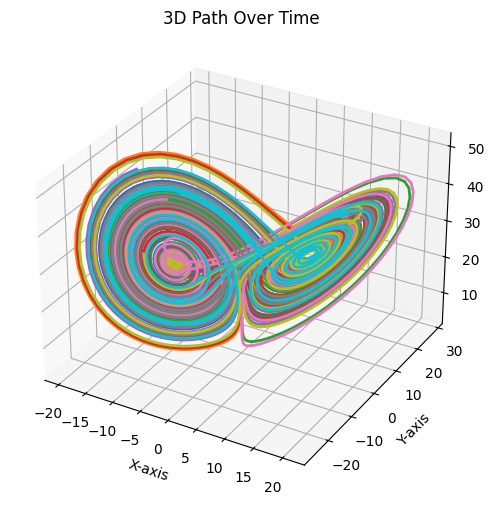

In [2]:
base_initial_condition = [10,20,30]
num_initial_conditions = 20
initial_conditions = generate_close_initial_conditions(base_initial_condition, num_initial_conditions)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for initial_condition in tqdm(initial_conditions):
    sigma, rho, beta = 10, 28, 8/3
    dt = 1e-2
    model = L63(sigma, rho, beta, dt)
    model.initialize([initial_condition[0],initial_condition[1],initial_condition[2]])
    for _ in range(1000):
        model.step()
    data = np.array(model.states)
    ax.plot(data[:,0], data[:,1], data[:,2], linewidth=2)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Path Over Time')

# Step 2: EnKF

In [3]:
H = np.eye(3)
R = np.eye(3)
dtda = 1e-2 # time between model step
oda = 1 # time between analyses
params = [10,28,8/3]
num_ensembles = 20
num_assimilations = 100
initial_conditions = [10,20,30]
solver = eakf_solver(params, initial_conditions, num_ensembles, L63, noise_strength=1.0)
sol = solver.run_eakf(H, R, dtda, oda, num_assimilations, inflation=3.0)

100%|██████████| 100/100 [00:00<00:00, 107.22it/s]


In [6]:
sol["observations"].shape

(1000, 3)

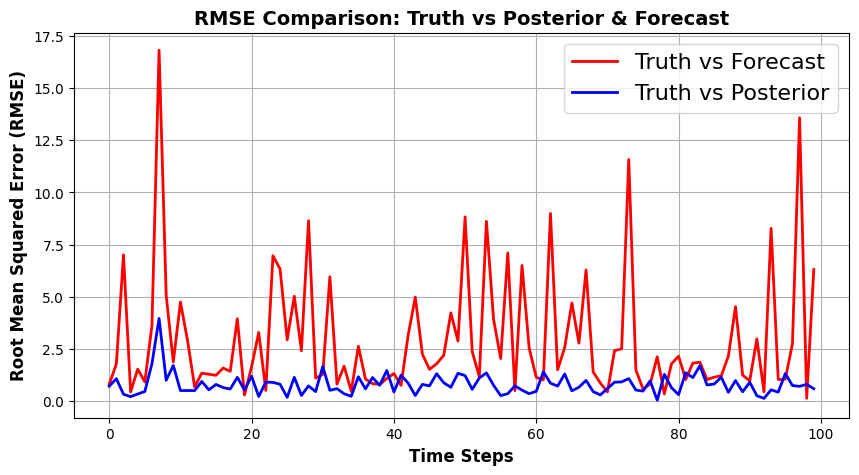

In [4]:
analysis = sol['analysis_states'].mean(-1)
background = sol['background_states'].mean(-1)
truth = sol['true_states']
mae_background = np.sqrt(np.mean((truth - background)**2, axis=1))
mae_analysis = np.sqrt(np.mean((truth - analysis)**2, axis=1))

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(mae_background, label="Truth vs Forecast", linewidth=2, color='red')
plt.plot(mae_analysis, label="Truth vs Posterior", linewidth=2, color='blue')

plt.xlabel("Time Steps", fontsize=12, fontweight='bold')
plt.ylabel("Root Mean Squared Error (RMSE)", fontsize=12, fontweight='bold')
plt.title("RMSE Comparison: Truth vs Posterior & Forecast", fontsize=14, fontweight='bold')
plt.legend(prop={'size': 16})
plt.grid()
plt.show()

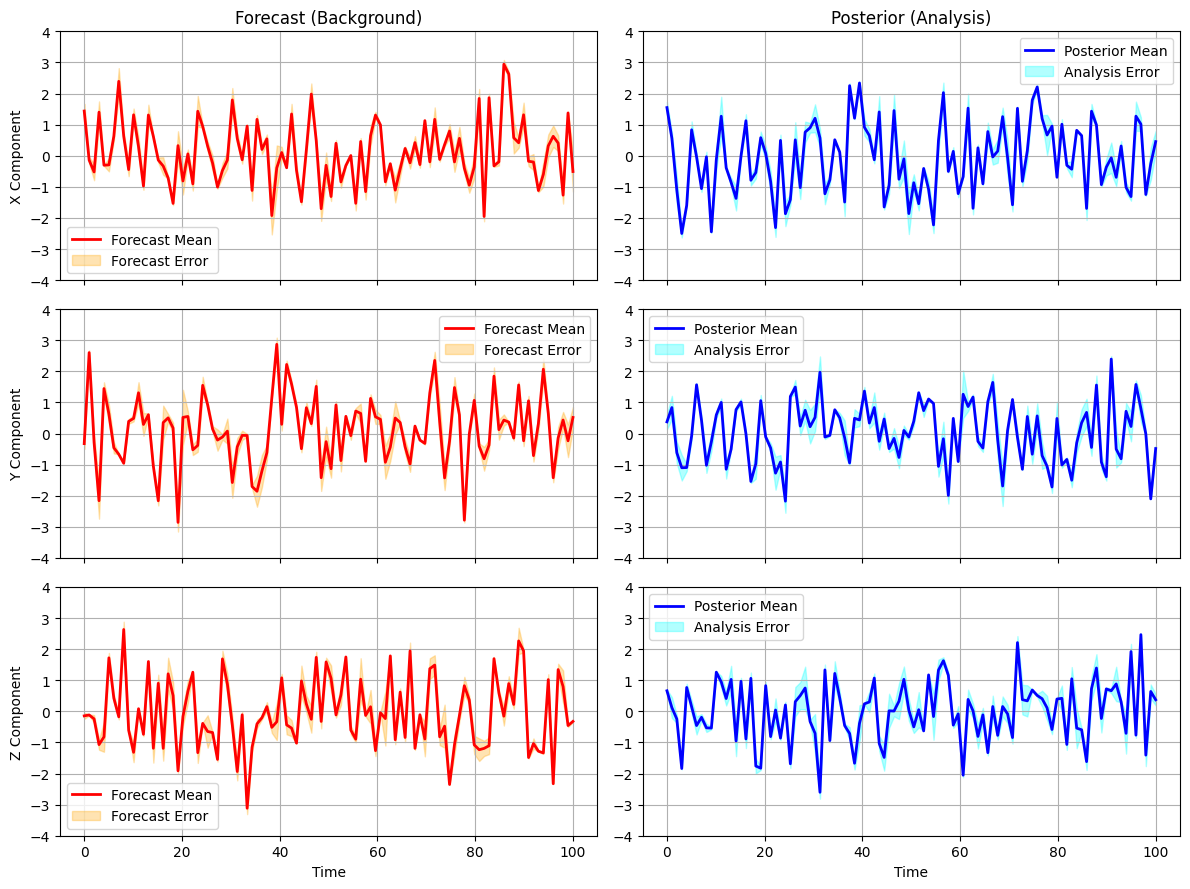

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Example time array (Replace with actual 't' from your data)
t = np.linspace(0, 100, 100)

# Example data (Replace with actual 'background', 'analysis', 'background_sd', 'analysis_sd')
background = np.random.randn(100, 3)
analysis = np.random.randn(100, 3)
background_sd = np.abs(np.random.randn(100, 3)) * 0.3
analysis_sd = np.abs(np.random.randn(100, 3)) * 0.3

# Create the figure and subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True)

# Component labels
components = ['X Component', 'Y Component', 'Z Component']

# Loop through components
for i in range(3):
    # Plot background (Forecast) in the left column
    axes[i, 0].plot(t, background[:, i], linewidth=2, color='red', label="Forecast Mean")
    axes[i, 0].fill_between(t, (background - background_sd)[:, i], (background + background_sd)[:, i],
                            color="orange", alpha=0.3, label="Forecast Error")
    axes[i, 0].set_ylabel(components[i])
    
    # Plot analysis (Posterior) in the right column
    axes[i, 1].plot(t, analysis[:, i], linewidth=2, color='blue', label="Posterior Mean")
    axes[i, 1].fill_between(t, (analysis - analysis_sd)[:, i], (analysis + analysis_sd)[:, i],
                            color="cyan", alpha=0.3, label="Analysis Error")
    axes[i, 0].legend()
    axes[i, 0].grid()
    axes[i, 0].set_ylim([-4,4])
    axes[i, 1].legend()
    axes[i, 1].grid()
    axes[i, 1].set_ylim([-4,4])

# Set titles for columns
axes[0, 0].set_title("Forecast (Background)")
axes[0, 1].set_title("Posterior (Analysis)")

# Common X-axis label
for ax in axes[-1, :]:
    ax.set_xlabel("Time")

# Add legends only in the first row


# Adjust layout
plt.tight_layout()
plt.show()


# Step 3: Generate Sample Paths

In [5]:
H = np.eye(3)
R = np.eye(3)
dtda = 1e-2 # time between model step
oda = 1 # time between analyses
params = [10,28,8/3]
num_ensembles = 20
num_assimilations = 1000

initial_conditions = [10,20,30]
solver = eakf_solver(params, initial_conditions, num_ensembles, L63)
sol = solver.run_eakf(H, R, dtda, oda, num_assimilations, inflation=3)
np.save(osj(os.getcwd(), "data", "train.npy"), sol)

initial_conditions = [20,30,10]
solver = eakf_solver(params, initial_conditions, num_ensembles, L63)
sol = solver.run_eakf(H, R, dtda, oda, num_assimilations, inflation=3)
np.save(osj(os.getcwd(), "data", "test.npy"), sol)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 101.72it/s]


# Step 4: RL trainer using PPO

In [2]:
sol = np.load(osj(os.getcwd(), "data", "example.npy"), allow_pickle=True).item()

In [5]:
# 1) Define a custom MLP extractor using the ensemble strategy
class EnsembleMLPExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 3):
        super(EnsembleMLPExtractor, self).__init__(observation_space, features_dim)
        self.ensemble_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(observation_space.shape[0], 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, features_dim),
                nn.ReLU(),
                
            ) for _ in range(observation_space.shape[1])
        ])
        self.num_nets = observation_space.shape[1]
    
    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        bsz = observations.shape[0]
        output = torch.cat([self.ensemble_nets[i](observations[:,:,i]).unsqueeze(-1) for i in range(self.num_nets)], dim=-1).reshape(bsz,-1)
        return output
    
class IdentityMLPExtractor(nn.Module):
    def __init__(self, features_dim: int):
        super(IdentityMLPExtractor, self).__init__()
        self.features_dim = features_dim
        self.latent_dim_pi = 60
        self.latent_dim_vf = 60
    def forward(self, features):
        return self.forward_actor(features), self.forward_critic(features)
    def forward_actor(self, features):
        return features
    def forward_critic(self, features):
        return features
    
class EnsembleMLPPolicy(ActorCriticPolicy):
    def __init__(self,observation_space,action_space,lr_schedule,*args,**kwargs,):
        # Disable orthogonal initialization
        kwargs["ortho_init"] = False
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            **{"features_extractor_class": EnsembleMLPExtractor},
        )
    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = IdentityMLPExtractor(self.features_dim)

In [ ]:
# 2) Define a custom environment
class L63RLAgent(Env):
    def __init__(self, solution_data, thresh=50, deterministic=False):
        super(L63RLAgent, self).__init__()
        self.solution_data = solution_data
        self.num_ensembles = solution_data["analysis_states"].shape[-1]
        self.timesteps = solution_data["true_states"].shape[0]
        self.idx = 1
        self.current_step = 0
        self.deterministic = deterministic
        
        # Define observation and action spaces
        vec_size = solution_data["true_states"].shape[1]
        self.observation_space = spaces.Box(low=-thresh, high=thresh, shape=(vec_size*4, self.num_ensembles), dtype=np.float32)
        self.action_space = spaces.Box(low=-thresh, high=thresh, shape=(vec_size*self.num_ensembles,), dtype=np.float32)
    
    def step(self, action):
        self.current_step += 1
        true_cleaned = self.solution_data["analysis_states"][self.idx].flatten()
        
        # Compute reward as negative RMSE
        rmse = np.sqrt(np.mean((true_cleaned - action) ** 2))
        reward = -rmse
        
        # Sample new random step
        obs = self._get_obs()
        done = self.deterministic and (self.idx==0)
        return obs, reward, done, done, {}
    
    def reset(self, seed=None, options=None):
        self.current_step = 0
        return self._get_obs(), {}
    
    def _get_obs(self):
        if self.deterministic:
            self.idx = (self.idx+1)%self.timesteps
        else:
            self.idx = np.random.randint(0, self.timesteps)  # Random step selection
        obs = np.concatenate([
            np.tile(np.expand_dims(self.solution_data['true_states'][self.idx], -1), 20),
            self.solution_data["previous_analysis"][self.idx],
            self.solution_data["background_states"][self.idx],
            self.solution_data["derivatives"][self.idx]
        ], axis=0) # shape = (12, 20)
        return obs.astype(np.float32)

In [7]:
# 3) Train the PPO model
total_timesteps = 50000
eval_freq = 1000

eval_callback = EvalCallback(
    L63RLAgent(sol, deterministic=True), 
    best_model_save_path=osj(os.getcwd(), "logs"),
    log_path=osj(os.getcwd(), "logs"), 
    eval_freq=eval_freq, 
    deterministic=True,
    render=False
)

model = PPO(
    EnsembleMLPPolicy,
    L63RLAgent(sol),
    verbose=1,
    device=device,
)
model.learn(
    total_timesteps=total_timesteps,
    callback=eval_callback,
    progress_bar=True
)
model.save("lorenz63")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

/root/miniconda3/envs/main/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: 
Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode 
lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor``
wrapper.
  warnings.warn(

Eval num_timesteps=1000, episode_reward=-15956.11 +/- 6.52

Episode length: 998.80 +/- 0.40

---------------------------------
| eval/              |          |
|    mean_ep_length  | 999      |
|    mean_reward     | -1.6e+04 |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------


New best mean reward!

Eval num_timesteps=2000, episode_reward=-15956.11 +/- 6.52

Episode length: 998.80 +/- 0.40

---------------------------------
| eval/              |          |
|    mean_ep_length  | 999      |
|    mean_reward     | -1.6e+04 |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------


-----------------------------
| time/              |      |
|    fps             | 81   |
|    iterations      | 1    |
|    time_elapsed    | 25   |
|    total_timesteps | 2048 |
-----------------------------


Eval num_timesteps=3000, episode_reward=-15964.82 +/- 6.54

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -1.6e+04  |
| time/                   |           |
|    total_timesteps      | 3000      |
| train/                  |           |
|    approx_kl            | 206.87688 |
|    clip_fraction        | 0.985     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -0.166    |
|    learning_rate        | 0.0003    |
|    loss                 | 195       |
|    n_updates            | 10        |
|    policy_gradient_loss | 0.238     |
|    std                  | 1         |
|    value_loss           | 1.02e+04  |
---------------------------------------


Eval num_timesteps=4000, episode_reward=-15964.82 +/- 6.54

Episode length: 998.80 +/- 0.40

---------------------------------
| eval/              |          |
|    mean_ep_length  | 999      |
|    mean_reward     | -1.6e+04 |
| time/              |          |
|    total_timesteps | 4000     |
---------------------------------


-----------------------------
| time/              |      |
|    fps             | 71   |
|    iterations      | 2    |
|    time_elapsed    | 56   |
|    total_timesteps | 4096 |
-----------------------------


Eval num_timesteps=5000, episode_reward=-18338.60 +/- 7.51

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -1.83e+04 |
| time/                   |           |
|    total_timesteps      | 5000      |
| train/                  |           |
|    approx_kl            | 2478.8438 |
|    clip_fraction        | 0.996     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -0.992    |
|    learning_rate        | 0.0003    |
|    loss                 | 424       |
|    n_updates            | 20        |
|    policy_gradient_loss | 0.273     |
|    std                  | 1         |
|    value_loss           | 4.95e+03  |
---------------------------------------


Eval num_timesteps=6000, episode_reward=-18338.60 +/- 7.51

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -1.83e+04 |
| time/              |           |
|    total_timesteps | 6000      |
----------------------------------


-----------------------------
| time/              |      |
|    fps             | 68   |
|    iterations      | 3    |
|    time_elapsed    | 89   |
|    total_timesteps | 6144 |
-----------------------------


Eval num_timesteps=7000, episode_reward=-20369.64 +/- 8.20

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -2.04e+04 |
| time/                   |           |
|    total_timesteps      | 7000      |
| train/                  |           |
|    approx_kl            | 830.82227 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -2.46     |
|    learning_rate        | 0.0003    |
|    loss                 | 464       |
|    n_updates            | 30        |
|    policy_gradient_loss | 0.258     |
|    std                  | 1         |
|    value_loss           | 4.17e+03  |
---------------------------------------


Eval num_timesteps=8000, episode_reward=-20369.64 +/- 8.20

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -2.04e+04 |
| time/              |           |
|    total_timesteps | 8000      |
----------------------------------


-----------------------------
| time/              |      |
|    fps             | 64   |
|    iterations      | 4    |
|    time_elapsed    | 126  |
|    total_timesteps | 8192 |
-----------------------------


Eval num_timesteps=9000, episode_reward=-22870.77 +/- 9.25

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -2.29e+04 |
| time/                   |           |
|    total_timesteps      | 9000      |
| train/                  |           |
|    approx_kl            | 748.5559  |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -4.94     |
|    learning_rate        | 0.0003    |
|    loss                 | 521       |
|    n_updates            | 40        |
|    policy_gradient_loss | 0.243     |
|    std                  | 1         |
|    value_loss           | 4.03e+03  |
---------------------------------------


Eval num_timesteps=10000, episode_reward=-22870.77 +/- 9.25

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -2.29e+04 |
| time/              |           |
|    total_timesteps | 10000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 63    |
|    iterations      | 5     |
|    time_elapsed    | 160   |
|    total_timesteps | 10240 |
------------------------------


Eval num_timesteps=11000, episode_reward=-28487.95 +/- 11.35

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -2.85e+04 |
| time/                   |           |
|    total_timesteps      | 11000     |
| train/                  |           |
|    approx_kl            | 4580.2705 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -5.12     |
|    learning_rate        | 0.0003    |
|    loss                 | 558       |
|    n_updates            | 50        |
|    policy_gradient_loss | 0.25      |
|    std                  | 1         |
|    value_loss           | 3.82e+03  |
---------------------------------------


Eval num_timesteps=12000, episode_reward=-28487.95 +/- 11.35

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -2.85e+04 |
| time/              |           |
|    total_timesteps | 12000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 63    |
|    iterations      | 6     |
|    time_elapsed    | 194   |
|    total_timesteps | 12288 |
------------------------------


Eval num_timesteps=13000, episode_reward=-31835.13 +/- 12.57

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -3.18e+04 |
| time/                   |           |
|    total_timesteps      | 13000     |
| train/                  |           |
|    approx_kl            | 1763.156  |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -5.1      |
|    learning_rate        | 0.0003    |
|    loss                 | 734       |
|    n_updates            | 60        |
|    policy_gradient_loss | 0.243     |
|    std                  | 1         |
|    value_loss           | 5.17e+03  |
---------------------------------------


Eval num_timesteps=14000, episode_reward=-31835.13 +/- 12.57

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -3.18e+04 |
| time/              |           |
|    total_timesteps | 14000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 62    |
|    iterations      | 7     |
|    time_elapsed    | 228   |
|    total_timesteps | 14336 |
------------------------------


Eval num_timesteps=15000, episode_reward=-36539.93 +/- 14.44

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -3.65e+04 |
| time/                   |           |
|    total_timesteps      | 15000     |
| train/                  |           |
|    approx_kl            | 1416.5958 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -4.22     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.1e+03   |
|    n_updates            | 70        |
|    policy_gradient_loss | 0.237     |
|    std                  | 1         |
|    value_loss           | 5.53e+03  |
---------------------------------------


Eval num_timesteps=16000, episode_reward=-36539.93 +/- 14.44

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -3.65e+04 |
| time/              |           |
|    total_timesteps | 16000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 62    |
|    iterations      | 8     |
|    time_elapsed    | 260   |
|    total_timesteps | 16384 |
------------------------------


Eval num_timesteps=17000, episode_reward=-40443.44 +/- 15.89

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -4.04e+04 |
| time/                   |           |
|    total_timesteps      | 17000     |
| train/                  |           |
|    approx_kl            | 1361.1018 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -3.69     |
|    learning_rate        | 0.0003    |
|    loss                 | 623       |
|    n_updates            | 80        |
|    policy_gradient_loss | 0.236     |
|    std                  | 1         |
|    value_loss           | 5.74e+03  |
---------------------------------------


Eval num_timesteps=18000, episode_reward=-40443.44 +/- 15.89

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -4.04e+04 |
| time/              |           |
|    total_timesteps | 18000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 62    |
|    iterations      | 9     |
|    time_elapsed    | 294   |
|    total_timesteps | 18432 |
------------------------------


Eval num_timesteps=19000, episode_reward=-44713.91 +/- 17.58

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -4.47e+04 |
| time/                   |           |
|    total_timesteps      | 19000     |
| train/                  |           |
|    approx_kl            | 1837.4307 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -2.27     |
|    learning_rate        | 0.0003    |
|    loss                 | 744       |
|    n_updates            | 90        |
|    policy_gradient_loss | 0.24      |
|    std                  | 1         |
|    value_loss           | 5.94e+03  |
---------------------------------------


Eval num_timesteps=20000, episode_reward=-44713.91 +/- 17.58

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -4.47e+04 |
| time/              |           |
|    total_timesteps | 20000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 62    |
|    iterations      | 10    |
|    time_elapsed    | 328   |
|    total_timesteps | 20480 |
------------------------------


Eval num_timesteps=21000, episode_reward=-50013.26 +/- 19.70

Episode length: 998.80 +/- 0.40

--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 999      |
|    mean_reward          | -5e+04   |
| time/                   |          |
|    total_timesteps      | 21000    |
| train/                  |          |
|    approx_kl            | 2394.101 |
|    clip_fraction        | 0.997    |
|    clip_range           | 0.2      |
|    entropy_loss         | -85.1    |
|    explained_variance   | -3.56    |
|    learning_rate        | 0.0003   |
|    loss                 | 2.59e+03 |
|    n_updates            | 100      |
|    policy_gradient_loss | 0.247    |
|    std                  | 1        |
|    value_loss           | 6.34e+03 |
--------------------------------------


Eval num_timesteps=22000, episode_reward=-50013.26 +/- 19.70

Episode length: 998.80 +/- 0.40

---------------------------------
| eval/              |          |
|    mean_ep_length  | 999      |
|    mean_reward     | -5e+04   |
| time/              |          |
|    total_timesteps | 22000    |
---------------------------------


------------------------------
| time/              |       |
|    fps             | 62    |
|    iterations      | 11    |
|    time_elapsed    | 362   |
|    total_timesteps | 22528 |
------------------------------


Eval num_timesteps=23000, episode_reward=-54374.79 +/- 21.38

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -5.44e+04 |
| time/                   |           |
|    total_timesteps      | 23000     |
| train/                  |           |
|    approx_kl            | 2375.6887 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -3.11     |
|    learning_rate        | 0.0003    |
|    loss                 | 948       |
|    n_updates            | 110       |
|    policy_gradient_loss | 0.238     |
|    std                  | 1         |
|    value_loss           | 7.31e+03  |
---------------------------------------


Eval num_timesteps=24000, episode_reward=-54374.79 +/- 21.38

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -5.44e+04 |
| time/              |           |
|    total_timesteps | 24000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 12    |
|    time_elapsed    | 397   |
|    total_timesteps | 24576 |
------------------------------


Eval num_timesteps=25000, episode_reward=-59227.25 +/- 23.18

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -5.92e+04 |
| time/                   |           |
|    total_timesteps      | 25000     |
| train/                  |           |
|    approx_kl            | 3060.4758 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -2.98     |
|    learning_rate        | 0.0003    |
|    loss                 | 2.6e+03   |
|    n_updates            | 120       |
|    policy_gradient_loss | 0.238     |
|    std                  | 1         |
|    value_loss           | 7.27e+03  |
---------------------------------------


Eval num_timesteps=26000, episode_reward=-59227.25 +/- 23.18

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -5.92e+04 |
| time/              |           |
|    total_timesteps | 26000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 13    |
|    time_elapsed    | 430   |
|    total_timesteps | 26624 |
------------------------------


Eval num_timesteps=27000, episode_reward=-64221.92 +/- 25.23

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -6.42e+04 |
| time/                   |           |
|    total_timesteps      | 27000     |
| train/                  |           |
|    approx_kl            | 18765.818 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -3.53     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.88e+03  |
|    n_updates            | 130       |
|    policy_gradient_loss | 0.249     |
|    std                  | 1         |
|    value_loss           | 7.54e+03  |
---------------------------------------


Eval num_timesteps=28000, episode_reward=-64221.92 +/- 25.23

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -6.42e+04 |
| time/              |           |
|    total_timesteps | 28000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 14    |
|    time_elapsed    | 463   |
|    total_timesteps | 28672 |
------------------------------


Eval num_timesteps=29000, episode_reward=-67115.72 +/- 26.47

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -6.71e+04 |
| time/                   |           |
|    total_timesteps      | 29000     |
| train/                  |           |
|    approx_kl            | 4154.9883 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -4.01     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.54e+03  |
|    n_updates            | 140       |
|    policy_gradient_loss | 0.224     |
|    std                  | 1         |
|    value_loss           | 7.14e+03  |
---------------------------------------


Eval num_timesteps=30000, episode_reward=-67115.72 +/- 26.47

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -6.71e+04 |
| time/              |           |
|    total_timesteps | 30000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 62    |
|    iterations      | 15    |
|    time_elapsed    | 495   |
|    total_timesteps | 30720 |
------------------------------


Eval num_timesteps=31000, episode_reward=-69030.88 +/- 27.25

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -6.9e+04  |
| time/                   |           |
|    total_timesteps      | 31000     |
| train/                  |           |
|    approx_kl            | 4737.1426 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -4.42     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.12e+03  |
|    n_updates            | 150       |
|    policy_gradient_loss | 0.233     |
|    std                  | 1         |
|    value_loss           | 6.83e+03  |
---------------------------------------


Eval num_timesteps=32000, episode_reward=-69030.88 +/- 27.25

Episode length: 998.80 +/- 0.40

---------------------------------
| eval/              |          |
|    mean_ep_length  | 999      |
|    mean_reward     | -6.9e+04 |
| time/              |          |
|    total_timesteps | 32000    |
---------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 16    |
|    time_elapsed    | 528   |
|    total_timesteps | 32768 |
------------------------------


Eval num_timesteps=33000, episode_reward=-71144.39 +/- 28.14

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -7.11e+04 |
| time/                   |           |
|    total_timesteps      | 33000     |
| train/                  |           |
|    approx_kl            | 5640.1836 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -3.86     |
|    learning_rate        | 0.0003    |
|    loss                 | 2.17e+03  |
|    n_updates            | 160       |
|    policy_gradient_loss | 0.236     |
|    std                  | 1         |
|    value_loss           | 5.94e+03  |
---------------------------------------


Eval num_timesteps=34000, episode_reward=-71144.39 +/- 28.14

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -7.11e+04 |
| time/              |           |
|    total_timesteps | 34000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 17    |
|    time_elapsed    | 562   |
|    total_timesteps | 34816 |
------------------------------


Eval num_timesteps=35000, episode_reward=-71926.10 +/- 28.50

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -7.19e+04 |
| time/                   |           |
|    total_timesteps      | 35000     |
| train/                  |           |
|    approx_kl            | 9565.12   |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -4.57     |
|    learning_rate        | 0.0003    |
|    loss                 | 666       |
|    n_updates            | 170       |
|    policy_gradient_loss | 0.237     |
|    std                  | 1         |
|    value_loss           | 5.03e+03  |
---------------------------------------


Eval num_timesteps=36000, episode_reward=-71926.10 +/- 28.50

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -7.19e+04 |
| time/              |           |
|    total_timesteps | 36000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 18    |
|    time_elapsed    | 595   |
|    total_timesteps | 36864 |
------------------------------


Eval num_timesteps=37000, episode_reward=-74227.51 +/- 29.28

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -7.42e+04 |
| time/                   |           |
|    total_timesteps      | 37000     |
| train/                  |           |
|    approx_kl            | 11514.74  |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -5.41     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.69e+03  |
|    n_updates            | 180       |
|    policy_gradient_loss | 0.234     |
|    std                  | 1         |
|    value_loss           | 4.12e+03  |
---------------------------------------


Eval num_timesteps=38000, episode_reward=-74227.51 +/- 29.28

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -7.42e+04 |
| time/              |           |
|    total_timesteps | 38000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 19    |
|    time_elapsed    | 628   |
|    total_timesteps | 38912 |
------------------------------


Eval num_timesteps=39000, episode_reward=-78546.45 +/- 31.07

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -7.85e+04 |
| time/                   |           |
|    total_timesteps      | 39000     |
| train/                  |           |
|    approx_kl            | 10349.952 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -5.49     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.38e+03  |
|    n_updates            | 190       |
|    policy_gradient_loss | 0.244     |
|    std                  | 1         |
|    value_loss           | 4.09e+03  |
---------------------------------------


Eval num_timesteps=40000, episode_reward=-78546.45 +/- 31.07

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -7.85e+04 |
| time/              |           |
|    total_timesteps | 40000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 20    |
|    time_elapsed    | 661   |
|    total_timesteps | 40960 |
------------------------------


Eval num_timesteps=41000, episode_reward=-79528.97 +/- 31.37

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -7.95e+04 |
| time/                   |           |
|    total_timesteps      | 41000     |
| train/                  |           |
|    approx_kl            | 11712.412 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -5.52     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.35e+03  |
|    n_updates            | 200       |
|    policy_gradient_loss | 0.259     |
|    std                  | 1         |
|    value_loss           | 3.78e+03  |
---------------------------------------


Eval num_timesteps=42000, episode_reward=-79528.97 +/- 31.37

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -7.95e+04 |
| time/              |           |
|    total_timesteps | 42000     |
----------------------------------


Eval num_timesteps=43000, episode_reward=-79528.97 +/- 31.37

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -7.95e+04 |
| time/              |           |
|    total_timesteps | 43000     |
----------------------------------
------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 21    |
|    time_elapsed    | 704   |
|    total_timesteps | 43008 |
------------------------------


Eval num_timesteps=44000, episode_reward=-84232.64 +/- 33.26

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -8.42e+04 |
| time/                   |           |
|    total_timesteps      | 44000     |
| train/                  |           |
|    approx_kl            | 12591.846 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -4.55     |
|    learning_rate        | 0.0003    |
|    loss                 | 498       |
|    n_updates            | 210       |
|    policy_gradient_loss | 0.276     |
|    std                  | 1         |
|    value_loss           | 3.81e+03  |
---------------------------------------


Eval num_timesteps=45000, episode_reward=-84232.64 +/- 33.26

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -8.42e+04 |
| time/              |           |
|    total_timesteps | 45000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 22    |
|    time_elapsed    | 736   |
|    total_timesteps | 45056 |
------------------------------


Eval num_timesteps=46000, episode_reward=-85795.74 +/- 33.90

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -8.58e+04 |
| time/                   |           |
|    total_timesteps      | 46000     |
| train/                  |           |
|    approx_kl            | 12490.449 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -2.65     |
|    learning_rate        | 0.0003    |
|    loss                 | 435       |
|    n_updates            | 220       |
|    policy_gradient_loss | 0.259     |
|    std                  | 1         |
|    value_loss           | 4.02e+03  |
---------------------------------------


Eval num_timesteps=47000, episode_reward=-85795.74 +/- 33.90

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -8.58e+04 |
| time/              |           |
|    total_timesteps | 47000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 23    |
|    time_elapsed    | 770   |
|    total_timesteps | 47104 |
------------------------------


Eval num_timesteps=48000, episode_reward=-86515.93 +/- 34.25

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -8.65e+04 |
| time/                   |           |
|    total_timesteps      | 48000     |
| train/                  |           |
|    approx_kl            | 18971.455 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -4.77     |
|    learning_rate        | 0.0003    |
|    loss                 | 811       |
|    n_updates            | 230       |
|    policy_gradient_loss | 0.244     |
|    std                  | 1         |
|    value_loss           | 3.86e+03  |
---------------------------------------


Eval num_timesteps=49000, episode_reward=-86515.93 +/- 34.25

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -8.65e+04 |
| time/              |           |
|    total_timesteps | 49000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 24    |
|    time_elapsed    | 802   |
|    total_timesteps | 49152 |
------------------------------


Eval num_timesteps=50000, episode_reward=-85464.86 +/- 33.86

Episode length: 998.80 +/- 0.40

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -8.55e+04 |
| time/                   |           |
|    total_timesteps      | 50000     |
| train/                  |           |
|    approx_kl            | 15052.689 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -3.35     |
|    learning_rate        | 0.0003    |
|    loss                 | 637       |
|    n_updates            | 240       |
|    policy_gradient_loss | 0.252     |
|    std                  | 1         |
|    value_loss           | 3.34e+03  |
---------------------------------------


Eval num_timesteps=51000, episode_reward=-85464.86 +/- 33.86

Episode length: 998.80 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 999       |
|    mean_reward     | -8.55e+04 |
| time/              |           |
|    total_timesteps | 51000     |
----------------------------------


------------------------------
| time/              |       |
|    fps             | 61    |
|    iterations      | 25    |
|    time_elapsed    | 836   |
|    total_timesteps | 51200 |
------------------------------
